# Hyun-Joon Yang
# yanghyun@usc.edu
# BISC 478
# HW3

In [1]:
from IPython.display import Image
from IPython.core.display import HTML

HTML("""
<style>
.output_png {
    display: table-cell;
    text-align: center;
    vertical-align: middle;
}
.output_jpeg {
    display: table-cell;
    text-align: center;
    vertical-align: middle;
}
</style>
""")

In [2]:
import numpy as np

# Question 1 [25 points]
#### Guide tree for MSA
Given below are five sequences: <br>
S1: GATTCA; S2: GTCTGA; S3: GATATT, S4: GTCAGC, S5: GAGACA. <br>
The pair-wise sequence alignments for S1-S4 are as follows:

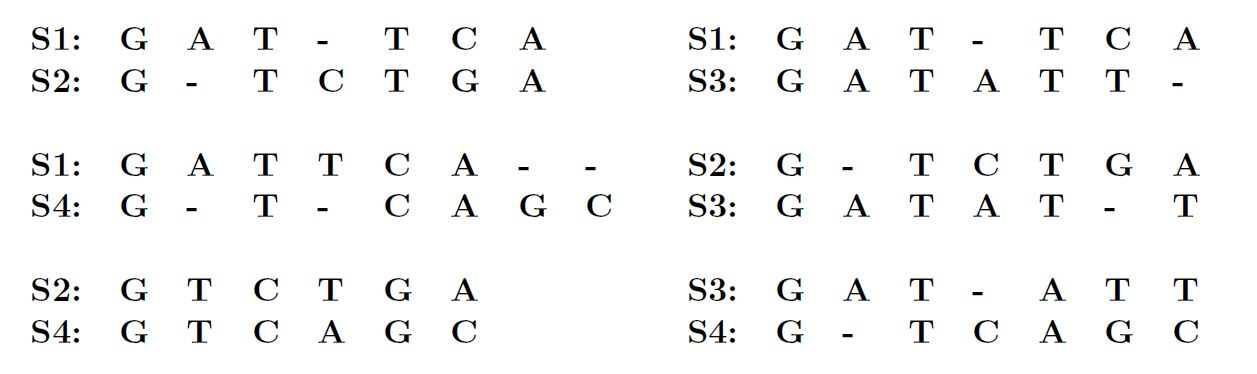

In [3]:
Image('img1-1.jpg')

## A) [10 points] Find pairwise alignment of S5 with other sequences. Use match score = 1 and -1 for mismatch and gap.

In [4]:
def getMatch(x: 'char', y: 'char', match_score: int, penalty_mismatch: int):
    """
    compares x and y and returns correct score depending on match or mismatch
    """
    if x == y:
        return match_score
    else:
        return penalty_mismatch

def fillM(X: str, Y: str, match_score: int, penalty_mismatch: int, penalty_gap: int):
    # create empty memoization matrix of size |X|+1 x |Y|+1
    M = np.empty((len(Y)+1,len(X)+1), dtype='int64')
    # initialze matrix with necessary default values
    for i in range(len(X)+1):
        M[0,i] = i * penalty_gap
    for j in range(len(Y)+1):
        M[j,0] = j* penalty_gap
    # fill in array
    # j => jth row, i => ith column
    for j in range(1, len(Y)+1):
        for i in range(1, len(X)+1):
            match = M[j-1,i-1] + getMatch(X[i-1], Y[j-1], match_score, penalty_mismatch)
            y_gap = M[j-1,i] + penalty_gap
            x_gap = M[j,i-1] + penalty_gap
            M[j,i] = max(match, y_gap, x_gap)
    return M

def findAlign(X: str, Y: str, M: 'numpy.ndarray', match_score: int, penalty_mismatch: int, penalty_gap: int):
    xlen = M.shape[1]
    ylen = M.shape[0]
    
    X = '_' + X
    Y = '_' + Y
    X_align = ''
    Y_align = ''
    opt_row = ylen-1
    opt_col = xlen-1
    
    if xlen == 1:
        return X_align, Y[1:]
    if ylen == 1:
        return X[1:], Y_align
    
    for row in range(ylen-1, -1, -1):
        for col in range(xlen-1, -1, -1):
            if opt_row == 0 and opt_col == 0:
                break
            if opt_row != row or opt_col != col:
                continue
            if M[row, col] == M[row-1, col-1] + getMatch(X[col], Y[row], match_score, penalty_mismatch):
                X_align += X[col]
                Y_align += Y[row]
                opt_row = row-1
                opt_col = col-1
            elif M[row, col] == M[row-1, col] + penalty_gap:
                X_align += '_'
                Y_align += Y[row]
                opt_row = row-1
            elif M[row, col] == M[row, col-1] + penalty_gap:
                X_align += X[col]
                Y_align += '_'
                opt_col = col-1
    return X_align[::-1], Y_align[::-1]


In [5]:
sequences = ['GATTCA', 'GTCTGA', 'GATATT', 'GTCAGC', 'GAGACA']
match = 1
mismatch = -1
gap = -1

for i in range(len(sequences)-1):
    m = fillM(sequences[i], sequences[-1], match, mismatch, gap)
    print('sequences:', i+1, len(sequences))
    print(findAlign(sequences[i], sequences[-1], m, match, mismatch, gap))

sequences: 1 5
('GATTCA', 'GAGACA')
sequences: 2 5
('GTCTGA', 'GAGACA')
sequences: 3 5
('GATATT', 'GAGACA')
sequences: 4 5
('GTCAG_C_', 'G__AGACA')


## B) [15 points] Construct a guide tree for MSA for these sequences.

In [6]:
def getDistanceScore(x: 'char', y: 'char', match: int, mismatch: int, gap: int):
    d_mismatch = mismatch * -1 + match
    d_gap = gap * -1 + match
    d_match = match * -1 + match
    if x == y:
        return d_match
    elif x == '-' or y == '-':
        return d_gap
    else:
        return d_mismatch
    
def getDistance(X: str, Y: str, match: int, mismatch: int, gap: int):
    assert len(X) == len(Y)
    d = 0
    for i in range(len(X)):
        d += getDistanceScore(X[i], Y[i], match, mismatch, gap)
    return d

def fillDistanceM(sequences: list, match: int, mismatch: int, gap: int):
    M = np.empty((len(sequences), len(sequences)), dtype='int64')
    for i in range(len(sequences)):
        for j in range(len(sequences)):
            m = fillM(sequences[i], sequences[j], match, mismatch, gap)
            X, Y = findAlign(sequences[i], sequences[j], m, match, mismatch, gap)
            M[i, j] = getDistance(X, Y, match, mismatch, gap)
    return M

def convertToDict(D):
    distances = {}
    for i in range(D.shape[0]):
        for j in range(D.shape[1]):
            if i != j:
                distances[(str(i+1),str(j+1))] = D[i,j]
                distances[(str(j+1),str(i+1))] = D[i,j]
    return distances

In [7]:
class TreeNode:
    def __init__(self, key, distance, left, right):
        self.key = key
        self.distance = distance
        self.left = left
        self.right = right
        if left is None and right is None:
            self.leaves = 1
        elif left is None:
            self.leaves = self.right.leaves
        elif right is None:
            self.leaves = self.left.leaves
        else:
            self.leaves = self.left.leaves + self.right.leaves
        
    def print_helper(self):
        if self.left is None and self.right is None:
            return (self.key, self.distance, (), ())
        elif self.left is None:
            return (self.key, self.distance, (), self.right.print_helper())
        elif self.right is None:
            return (self.key, self.distance, self.left.print_helper(), ())
        return (self.key, self.distance, self.left.print_helper(), self.right.print_helper())
        
    def print(self):
        print(self.print_helper())

def findClosestPair(distances):
    """
    takes dictionary of distances and returns the key for the pair of nodes that are closest
    :param distance: dictionary of distances
    :return: key for the pair of nodes that are closest
    """
    key_min = list(distances.keys())[0]
    for key in distances:
        if distances[key] < distances[key_min]:
            key_min = key
    return key_min

def calcDist(new_node, node, distances):
    """
    calculates the distance between a newly made node and another node
    :param new_node: new TreeNode
    :param node: TreeNode
    :param distances: dictionary containing all the distances of parentless nodes (aside from children of new node)
    :return: distance between the new node and another node
    """
    key = (new_node.key, node.key)
    if key in distances:
        return distances[key]
    left = new_node.left
    right = new_node.right
    if node == left or node == right:
        return distances[(left.key, right.key)] / 2
    distance_left = distances[(left.key, node.key)] * left.leaves
    distance_right = distances[(right.key, node.key)] * right.leaves
    distance = (distance_left + distance_right) / new_node.leaves
    return distance

def updateDist(distances, new_node, nodes):
    """
    updates the dictionary by adding the distances between the new node and all the other nodes
    and removing old distances
    :param distances: dictionary of distances
    :param new_node: newly made TreeNode
    :param nodes: dictionary that maps keys to TreeNodes that do not have parent
    :return: updated dictionary
    """
    left = new_node.left.key
    right = new_node.right.key
    
    # add new distances
    for key in nodes:
        distance = calcDist(new_node, nodes[key], distances)
        distances[(new_node.key, key)] = distance
        distances[(key, new_node.key)] = distance
    # remove old distances
    keys = list(distances.keys())
    for key in keys:
        if new_node.key in key:
            continue
        if key[0] not in nodes or key[1] not in nodes:
            del distances[key]
    return distances

def upgma(distances, leafList):
    # dict for all the nodes that do not have a parent
    # maps key to node
    nodes = {}
    # create TreeNodes for all leaf nodes
    for leaf in leafList:
        node = TreeNode(leaf, 0, None, None)
        nodes[leaf] = node
    # remove all distances to self
    keys = list(distances.keys())
    for key in keys:
        if key[0] == key[1]:
            del distances[key]
    # add to tree using upgma until root reached
    while len(nodes) > 1:
        # instantiate new parent node
        key_min = findClosestPair(distances)
        key = '(' + key_min[0] + ',' + key_min[1] +')'
        left = nodes[key_min[0]]
        right = nodes[key_min[1]]
        new_node = TreeNode(key, -1, left, right)
        # calculate distance to children
        dist_left = calcDist(new_node, new_node.left, distances)
        dist_right = calcDist(new_node, new_node.right, distances)
#         print(new_node.key, new_node.left.key, new_node.right.key, dist_left, dist_right)
        assert dist_left == dist_right
        new_node.distance = dist_left
        # remove children from nodes dict
        del nodes[key_min[0]]
        del nodes[key_min[1]]
        # get updated distances & remove distances of children
        distances = updateDist(distances, new_node, nodes)
        # add new node into nodes dict
        nodes[key] = new_node
#         print(nodes.keys())
#         print(distances)
    # return root
    key_root = list(nodes.keys())[0]
    return nodes[key_root]

In [8]:
D = fillDistanceM(sequences, match, mismatch, gap)
distances = convertToDict(D)
# print(D)
# print(distances)
leaves = []
for i in range(5):
    leaves.append(str(i+1))
root = upgma(distances, leaves)
root.print()

('(((1,5),3),(2,4))', 3.8333333333333335, ('((1,5),3)', 3.0, ('(1,5)', 2.0, ('1', 0, (), ()), ('5', 0, (), ())), ('3', 0, (), ())), ('(2,4)', 2.0, ('2', 0, (), ()), ('4', 0, (), ())))


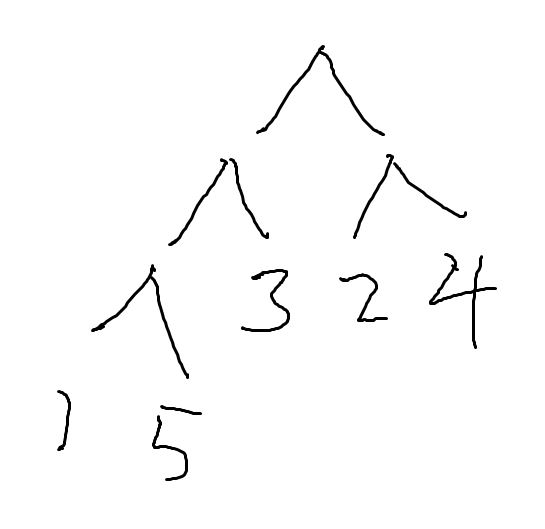

In [9]:
Image('img1-2.jpg')

# Question 2 [20 points]
#### MSA of Alu repeats
Go to [UCSC Table Browser](http://genome.ucsc.edu/cgi-bin/hgTables). Find the DNA sequences (in FASTA format) for all repeats
that belong to the **Alu** family, and are located within the genomic region chr12:56,735,000-
56,750,000 of human GRCh38/hg38 assembly in RepeatMasker track (under repeats group).
Select output format to be "sequence". Tutorial about Table Browser can be found [here](https://genome.ucsc.edu/training/).
Answer the following questions based on the output from the Table Browser.

In [10]:
with open('result.FASTA', 'r') as f:
    print(f.read())

>hg38_rmsk_AluSx3 range=chr12:56734811-56735110 5'pad=0 3'pad=0 strand=- repeatMasking=none
GACCGGGCGCGGTGGCTCACGCCTGTAATCCCAGCACTTTGGGAGGCCAA
AGTGGGTGAATCATGAGGTCAGGAGTTTGAGACCAGCCTGGCCAACATGG
TGAAACCCTATCTCTACTAAAAATACAAAAAATTAGCTCATTGTGGTGGC
GGGCACCTATAATCCCAGCTAGTCGGGAGGCTGAGGTAGGAGAATTGCTT
GAACCTGGGAGGCGGAAGTTGCAGTAAGCCGAGATCGCACCATTGCACTC
CAGCCTGGGCAACAGAGTGACACTCTGTCTCAAAAAAAAAAAAAAAGAAA
>hg38_rmsk_AluSc range=chr12:56735126-56735397 5'pad=0 3'pad=0 strand=- repeatMasking=none
GGCCGGGCACGGTGGCTCACGCCTGTAATCCCAGCACTTTGGGAGACTGA
GGCAGGTGGATCACGAGGTCAAGAGATCAAAACCATCTTGGACAGCATGG
TGAAACCCCGTCTCTACTAAAAATACAAAAACTTAGCCGGGCATGGTGGC
ACACACCTATAGTCCCAGCTACTCAGGAGGCTGAGGCAGGAGAATCGCTT
GAACTCGGGAGGCGGAGGTTCCCGAGCCAAGATTGCACCACTGCATACCA
GCCTGGCAACAGAGCAAGACTC
>hg38_rmsk_AluJr range=chr12:56735408-56735621 5'pad=0 3'pad=0 strand=- repeatMasking=none
CCAAAAGGGCGTGACCAGAGCCTGAGCAACACAAGACCTTGTCTCTACTA
AAAATAAAAAATTAGCCAGCTGTGGTGGCACTCCCTGTGATCCCAGCTAC
TTGGGAGGCTGAGGTGGGAGGATCATTTAAGCCAGGGAAG

## A) [8 points] How many Alu repeats are there in the result?

In [11]:
with open('result.FASTA', 'r') as f:
    i = 0
    for line in f:
        if line[0] == '>':
            i += 1
    print(i)

25


25 repeats

## B) [2 points] How many unique repeat names are there in the result?

In [12]:
with open('result.FASTA', 'r') as f:
    masks = set()
    for line in f:
        if line[0] == '>':
            info = line.split()
            mask = info[0].split('_')[-1]
            masks.add(mask)
    print(len(masks))

14


14 unique repeat names

## C) [10 points] Take any one sequence for the following repeats:  AluJb,AluJo,AluJr,AluSc,AluSg,AluSp,AluSx and AluSz. Use the EBI multiple sequence alignment tool [Clustal Omega](https://www.ebi.ac.uk/Tools/msa/clustalo/) to align these sequences.

In [13]:
s = '''>hg38_rmsk_AluJb range=chr12:56736810-56737062 5'pad=0 3'pad=0 strand=- repeatMasking=none
CTCACACCTGTAATCCCAGCACTTTGGGAGGCCGAGGCAAGAGGAGCCTA
GGAGTTTGAGACCACCCTGGGCAACACAGAGAGACCCTGTCTCTCCAAAA
AAAAAAATTTAGCTAGACATGCTGGCAGGCACCTGTGGTCTCAGCTACTC
AAGAGGCTGTTTGAGCCCAGGAGGTTAAGGCTGCAGTAAGCCTTGACCAC
ACCACTGTACTCCAGCCTGGGTGTCAGAGAGAGACCTTGTCTCAAAATGA
AAA
>hg38_rmsk_AluJo range=chr12:56745130-56745438 5'pad=0 3'pad=0 strand=+ repeatMasking=none
GGCTGGATGTAGTGGCTCACACCTGTAATCTCAGCATTTTGGGAGCCTGA
AGTGGGAGGATAGTTTGAGTTTAGGAGTTCAAGAACACCCTGGGCAATAT
AGTGAGACCTTGTTTCTGCAAAAATTAAAAAATTGGCTGGGCGTGGTGGC
GCATGCCTTTAGTCCCAGCTACTCAGGAGGCTGAGGTAGAAGGGTCACTT
GAGACCAGGAGGTCAAGGCTGCAGTGAGCTGTGGTCACGTTACCGTACTC
CAGCCTGGGTGACAGGGTGAGACCGTGTCTCAAAACAAAACAAAACAAAA
CAAAAAAAA
>hg38_rmsk_AluJr range=chr12:56735408-56735621 5'pad=0 3'pad=0 strand=- repeatMasking=none
CCAAAAGGGCGTGACCAGAGCCTGAGCAACACAAGACCTTGTCTCTACTA
AAAATAAAAAATTAGCCAGCTGTGGTGGCACTCCCTGTGATCCCAGCTAC
TTGGGAGGCTGAGGTGGGAGGATCATTTAAGCCAGGGAAGTCAAAGCTGC
AGTGAGCTGCAATTGCACCACTGCATTCTAGCCTGGGCAAAAAAGCAAGA
CAGTGTCTCAAAAA
>hg38_rmsk_AluSc range=chr12:56738549-56738844 5'pad=0 3'pad=0 strand=- repeatMasking=none
GGCGCGGTGGCTCATGCCTGTAATCCCAACACTTTGGGAGGGCAAAGCGC
GTGGATCACAAGGTCAAGAGATCGAGACCATCCTGGCCAACATGGTGAAA
CCCTGTCTCTACTAAAAATACAAAAATTAGCTGCGCTTGGTGGCATATGC
CTGTAGTCCCAGCTACTTGGGAGGCTGAGGCAGAAGAATCACTTGAACCT
GGGAGGCGGAGGTTGCAGTGAGCCAAGATCGCACCACCACACTCCGGCCT
GGCAACAGAGCAAGACTCCGTCTCAAAAACAAAAACAAAAACAAAA
>hg38_rmsk_AluSg range=chr12:56742302-56742597 5'pad=0 3'pad=0 strand=+ repeatMasking=none
GGCCGGGCACAGTGGCTCATGCCTGTATTCCCAATATTTTGGGAGGCTGA
GGTGGGTGGATCATTTGAGACCAGCTTGGCTGACATGGTGAGACCCCGTC
TCTATAAAAACACAAAAATTAGCTGGGCGTGGTGGCGTGTGCCTGCAGTC
CCAGCTATTTGGGAGGCTGAGGCAGGAGAATTGTTTGAACCCGGGAGGCG
GAGGTTGCAGTAAGCCAAGATCACACCACTGCACACTCCAGCCTGGGCAA
CACAGTATAAGACTCCGTCTTAAAAACAACAACAACAACAAAAAAA
>hg38_rmsk_AluSp range=chr12:56737352-56737648 5'pad=0 3'pad=0 strand=- repeatMasking=none
GGCCAGGCGCGATGGCTCACACCTGTAATCCCAGCACTTTGGGAGGCCCA
GGTGGGTTGATCACCTGAGGTCCTGAGTTCGAGACCGGCCTGACCAACAT
GGAGAAACCCTGTCTATCCTAAAAATACAGAATTAGCCGGCTGTGGTGGC
ACATGCCTGTAATCCCAGCTGCTCGGAAGGCAGAGGCAGGAGAATCGCTT
GAACTCAGGAGGTGGAGGTTGCGGTGAGCCAAGATCACGCCATTGCACTC
CAGCCTGGGCAACAAGAGCAAAACTCCGTCTCAAAAAAAAAAAAAAA
>hg38_rmsk_AluSx range=chr12:56741971-56742262 5'pad=0 3'pad=0 strand=+ repeatMasking=none
GACTGGGCGTGGTGGCTCATGCCTGTACTCCCAGCACTTTGGGAGGCAGA
GGTGGGTGGATCACGTGAGGTCAGGAGATCGAGACCAGCCTGGCCAACAT
GGTGAAACCCCATCTCTACTAAAAATAGAAAAATCAGCAGGGCATGGTGG
TGCACATCTGTAATCCTAGCTACTCTGGAGGCTGAGGCAGGAAAATTGCT
TAAATCTGCAAGGTGAAGGTTGCAGTGAGCTGAGATTGTGCCACTGTGCT
ACAGCCTGGGCAACAGAGTGAGACTCCATCTCAACAACAAAA
>hg38_rmsk_AluSz range=chr12:56747465-56747755 5'pad=0 3'pad=0 strand=+ repeatMasking=none
GCTGGGCACAGTGGCTCATGCCTGTAATCCCAGCACTTTGAGAGGCTGAG
GCGGGCAGATCACTTGAGGTCAGGAGTTTGAAACCAGCCTGGCCAATATG
GTGAAACTGTCTCCCTACTAAAGATACAAAAAATAGCCGGGTGTGATGGC
ATATGCCTGTAGTCCCAGCTACTTGGGAAGCTGAAGCAGGAGTATCATTG
AACCCGGGAGGTGGAAGTTGCTGTGAGTCAAGATCACGCCACTGCACTCC
AGCCTGGGTGACAGAGCGAGACTCTGTCTCAAAAAAAAGAA'''
print(s)

>hg38_rmsk_AluJb range=chr12:56736810-56737062 5'pad=0 3'pad=0 strand=- repeatMasking=none
CTCACACCTGTAATCCCAGCACTTTGGGAGGCCGAGGCAAGAGGAGCCTA
GGAGTTTGAGACCACCCTGGGCAACACAGAGAGACCCTGTCTCTCCAAAA
AAAAAAATTTAGCTAGACATGCTGGCAGGCACCTGTGGTCTCAGCTACTC
AAGAGGCTGTTTGAGCCCAGGAGGTTAAGGCTGCAGTAAGCCTTGACCAC
ACCACTGTACTCCAGCCTGGGTGTCAGAGAGAGACCTTGTCTCAAAATGA
AAA
>hg38_rmsk_AluJo range=chr12:56745130-56745438 5'pad=0 3'pad=0 strand=+ repeatMasking=none
GGCTGGATGTAGTGGCTCACACCTGTAATCTCAGCATTTTGGGAGCCTGA
AGTGGGAGGATAGTTTGAGTTTAGGAGTTCAAGAACACCCTGGGCAATAT
AGTGAGACCTTGTTTCTGCAAAAATTAAAAAATTGGCTGGGCGTGGTGGC
GCATGCCTTTAGTCCCAGCTACTCAGGAGGCTGAGGTAGAAGGGTCACTT
GAGACCAGGAGGTCAAGGCTGCAGTGAGCTGTGGTCACGTTACCGTACTC
CAGCCTGGGTGACAGGGTGAGACCGTGTCTCAAAACAAAACAAAACAAAA
CAAAAAAAA
>hg38_rmsk_AluJr range=chr12:56735408-56735621 5'pad=0 3'pad=0 strand=- repeatMasking=none
CCAAAAGGGCGTGACCAGAGCCTGAGCAACACAAGACCTTGTCTCTACTA
AAAATAAAAAATTAGCCAGCTGTGGTGGCACTCCCTGTGATCCCAGCTAC
TTGGGAGGCTGAGGTGGGAGGATCATTTAAGCCAGGGAAGTCAAAGCTGC

### 1) What is the percentage identity between AluJo and AluSp?

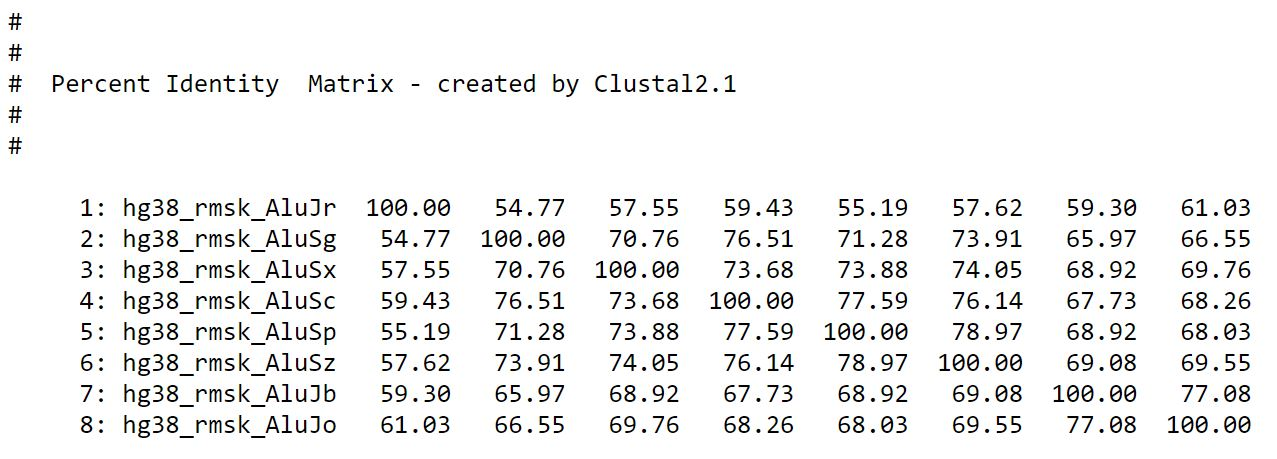

In [14]:
Image('img2-3-1.jpg')

68.03%

### 2) Find the phylogenetic tree based on the MSA.

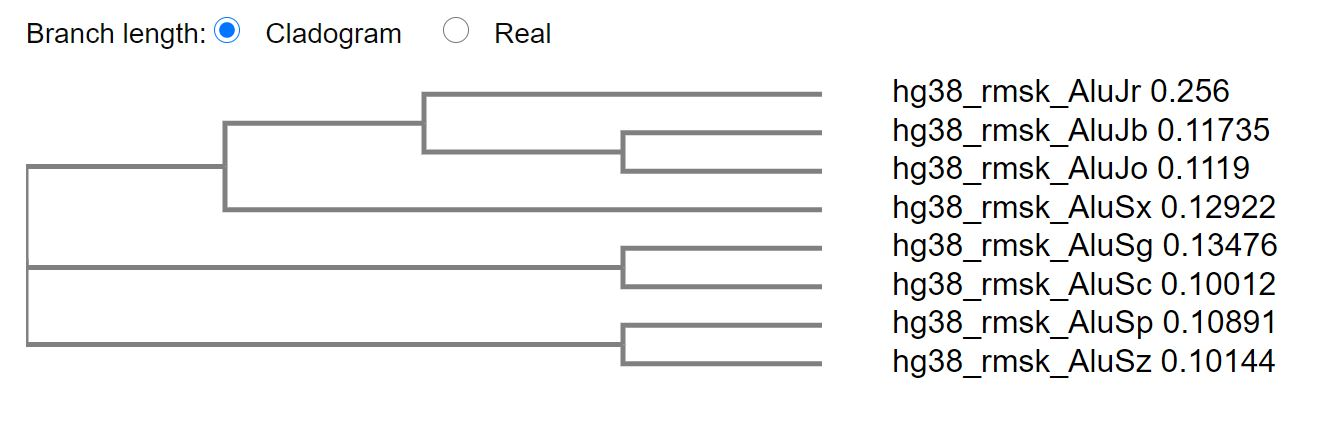

In [15]:
Image('img2-3-2.jpg')

# Question 3 [25 points]
#### De Bruijn graph

## A) [5 points] Construct a De Bruijn graph for r1 = CGATTCTAAGT for k = 4?

In [16]:
def scanEdge(edge, sequences):
    indices = set()
    for i in range(len(sequences)):
        for j in range(len(sequences[i])-len(edge)+1):
            if edge == sequences[i][j:j+len(edge)]:
                indices.add((i, j))
    return indices
def enumerateEdges(sequences, k):
    edges = {}
    for i in range(len(sequences)):
        for j in range(len(sequences[i])-k+1):
            edge = sequences[i][j:j+k]
            if edge not in edges:
                indices = scanEdge(edge, sequences)
                edges[edge] = indices
    return edges

def scanNeighbors(node, edges):
    neighbors = set()
    for edge in edges:
        for j in range(len(edge)-len(node)+1):
            if node == edge[j:j+len(node)]:
                if j+len(node) < len(edge):
                    neighbors.add(edge[j+1:j+len(node)+1])
    return neighbors

def enumerateNodes(edges, k):
    nodes = {}
    for edge in edges:
        for j in range(len(edge)-(k-1)+1):
            node = edge[j:j+(k-1)]
            if node not in nodes:
                neighbors = scanNeighbors(node, edges)
                nodes[node] = neighbors
    return nodes

In [17]:
sequences1 = ['GTGCCG', 'GCCGCA', 'ATGTG', 'TGTGCC']
k1 = 3

In [18]:
sequences1 = ['CGATTCTAAGT']
k1 = 4

In [19]:
edges1 = enumerateEdges(sequences1, k1)
edges1

{'CGAT': {(0, 0)},
 'GATT': {(0, 1)},
 'ATTC': {(0, 2)},
 'TTCT': {(0, 3)},
 'TCTA': {(0, 4)},
 'CTAA': {(0, 5)},
 'TAAG': {(0, 6)},
 'AAGT': {(0, 7)}}

In [20]:
nodes1 = enumerateNodes(edges1, k1)
nodes1

{'CGA': {'GAT'},
 'GAT': {'ATT'},
 'ATT': {'TTC'},
 'TTC': {'TCT'},
 'TCT': {'CTA'},
 'CTA': {'TAA'},
 'TAA': {'AAG'},
 'AAG': {'AGT'},
 'AGT': set()}

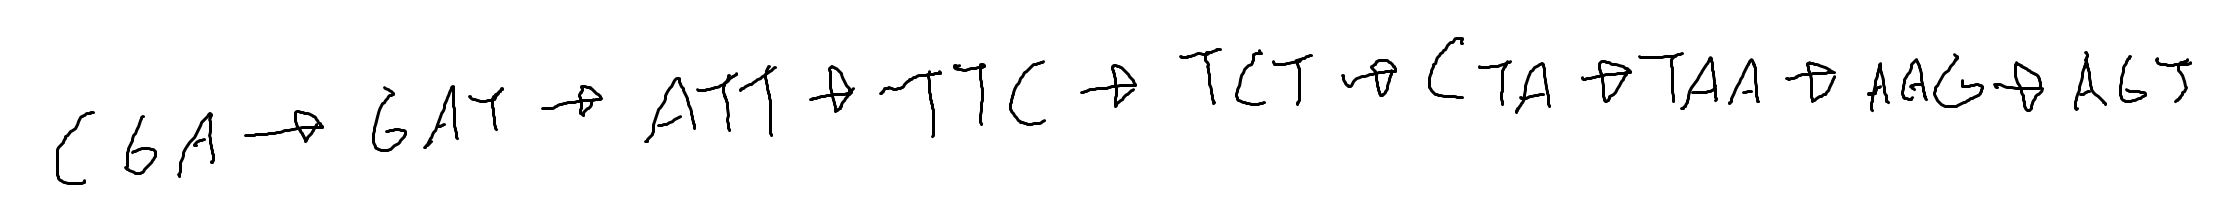

In [21]:
Image('img3-1.jpg')

## B) [5 points] Now construct a De Bruijn graph for k = 4 given the information that there is a single-nucleotide variant (C/G) at position 6 of r1. <br><br> Hint: Now there are two possible sequences and you have to construct the graph for <br> r1 = CGATTCTAAGT r2 = CGATTGTAAGT

In [22]:
sequences2 = ['CGATTCTAAGT', 'CGATTGTAAGT']
k2 = 4

In [23]:
edges2 = enumerateEdges(sequences2, k2)
edges2

{'CGAT': {(0, 0), (1, 0)},
 'GATT': {(0, 1), (1, 1)},
 'ATTC': {(0, 2)},
 'TTCT': {(0, 3)},
 'TCTA': {(0, 4)},
 'CTAA': {(0, 5)},
 'TAAG': {(0, 6), (1, 6)},
 'AAGT': {(0, 7), (1, 7)},
 'ATTG': {(1, 2)},
 'TTGT': {(1, 3)},
 'TGTA': {(1, 4)},
 'GTAA': {(1, 5)}}

In [24]:
nodes2 = enumerateNodes(edges2, k2)
nodes2

{'CGA': {'GAT'},
 'GAT': {'ATT'},
 'ATT': {'TTC', 'TTG'},
 'TTC': {'TCT'},
 'TCT': {'CTA'},
 'CTA': {'TAA'},
 'TAA': {'AAG'},
 'AAG': {'AGT'},
 'AGT': set(),
 'TTG': {'TGT'},
 'TGT': {'GTA'},
 'GTA': {'TAA'}}

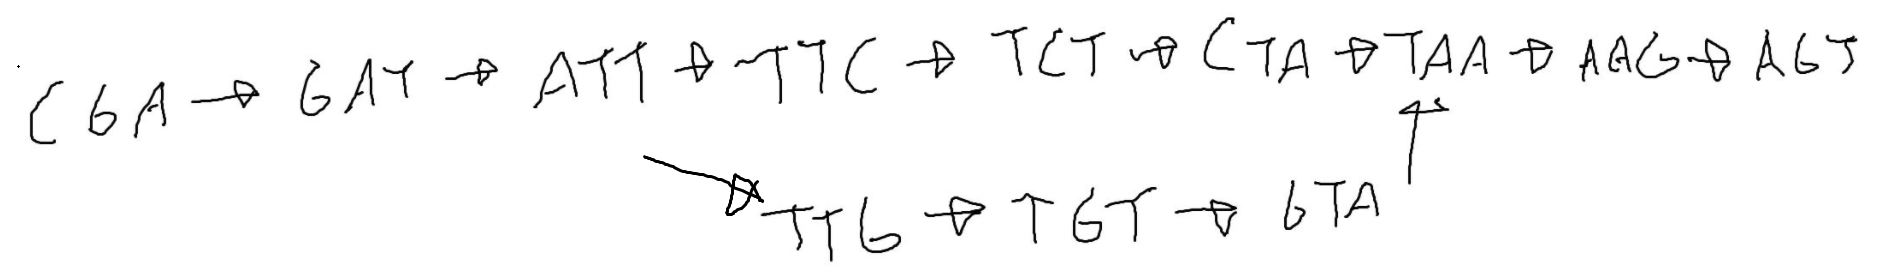

In [25]:
Image('img3-2.jpg')

## C) [5 points] How many extra nodes are present in the graph (b) compared to the graph in part (a)?

In [26]:
len(nodes2)-len(nodes1)

3

## D) [10 points] A 1Mb diploid genome is sequenced by a technology that produces perfect reads. There are no repeats in the genome longer than 25 bases, but there is a single-nucleotide variant every 1,000 bases. Assuming error-free sequencing by 100-base reads only from the forward strand and the spacing between two SNPs is greater than 50 bases, how many nodes are in the resulting De Bruijn graph built with k = 27

(100 - 27 + 1) * (1000000 / 100) + (1000000 / 1000) = 741000